# Revised/Optimised code to simulate 100,000 X 100,000 Pixels of images

Refer to previous implementation at [https://github.com/Nikjin/DragonFruit_challenge/blob/main/DragonFruit_Challenge.ipynb](https://github.com/Nikjin/DragonFruit_challenge/blob/main/DragonFruit_Challenge.ipynb)


You can check out this same notebook over Kaggle.
Here's the link [https://www.kaggle.com/code/nikjin/optimised-code-df](https://www.kaggle.com/code/nikjin/optimised-code-df)

### Note: Below code should run easily for 16 GB RAM System. However, I would suggest to run for Parasite with Cancer first, then restart the notebook and run it for Parasite with No Cancer to avoid kernel crash.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm
import time


np.random.seed(42)


def generate_complex_blob(image_size=(100000, 100000), occupancy_ratio=None, max_leakage_ratio=0.25):
    start_time = time.time()

    if occupancy_ratio is None:
        occupancy_ratio = np.random.uniform(0.25, 0.75)

    img = np.zeros(image_size, dtype=np.uint8)
    img1 = np.zeros(image_size, dtype=np.uint8) # Modified version of parasite image, will be used for dye image

    required_area = image_size[0] * image_size[1] * occupancy_ratio

    max_radius = min(image_size) // 2
    radius = int((required_area / np.pi) ** 0.5)
    radius1 = int(radius * 1.2)

    if radius > max_radius:
        radius = max_radius
    if radius1 > max_radius:
        radius1 = max_radius

    max_leakage = int(max_radius * max_leakage_ratio)
    margin = radius + max_leakage
    margin = min(margin, max_radius)

    center_x_range = (margin, image_size[1] - margin)
    center_y_range = (margin, image_size[0] - margin)

    center_x = np.random.randint(*center_x_range) if center_x_range[0] < center_x_range[1] else image_size[1] // 2
    center_y = np.random.randint(*center_y_range) if center_y_range[0] < center_y_range[1] else image_size[0] // 2

    center = (center_x, center_y)
    axes = (radius, int(radius * np.random.uniform(0.5, 1)))
    axes1 = (radius1, int(radius1 * np.random.uniform(0.5, 1)))

    angle = np.random.randint(0, 360)
    cv2.ellipse(img, center, axes, angle, 0, 360, 1, -1)

    line_thickness = max(image_size) // 500  # Adjust line thickness based on image size
    for theta in range(360):
        theta_rad = np.radians(theta)
        r_variation = np.random.uniform(0.9, 1.1)  # Increase variation for larger images
        x_irr = center_x + int(axes1[0] * r_variation * np.cos(theta_rad))
        y_irr = center_y + int(axes1[1] * r_variation * np.sin(theta_rad))
        cv2.line(img1, center, (x_irr, y_irr), 1, line_thickness)

    end_time = time.time()
    print(f"generate_complex_blob execution time: {end_time - start_time:.4f} seconds")

    return img, img1



def generate_dye_distribution(parasite_img, is_cancerous=False, chunk_size=4000):
    start_time = time.time()
    leakage_ratio = 0.2
    
    if is_cancerous:
        # Explicitly set a high lit_ratio for cancerous image
        lit_ratio = 0.4  # 40% lit, ensuring cancer
    else:
        # Ensure non-cancerous images have a low lit_ratio
        lit_ratio = np.random.uniform(0.15, 0.2)  # Low chance of cancer
        
    dye_img = np.zeros_like(parasite_img, dtype=np.uint8)  # Initialize the dye image
    
    # Process the image in chunks to save memory
    for i in range(0, parasite_img.shape[0], chunk_size):
        for j in range(0, parasite_img.shape[1], chunk_size):
            chunk = parasite_img[i:i+chunk_size, j:j+chunk_size]
            random_mask_chunk = np.random.rand(chunk.shape[0], chunk.shape[1]) < lit_ratio
            dye_chunk = np.where(random_mask_chunk, chunk, 0).astype(np.uint8)
            dye_img[i:i+chunk_size, j:j+chunk_size] = dye_chunk

    end_time = time.time()
    print(f"generate_dye_distribution execution time: {end_time - start_time:.4f} seconds")

    return dye_img


def has_cancer(parasite_img, dye_img, cancer_threshold=0.1, chunk_size=4000):
    start_time = time.time()

    # Initialize counters for parasite and lit dye areas
    total_parasite_area = 0
    total_lit_dye_area = 0

    # Process the image in chunks to save memory
    for i in range(0, parasite_img.shape[0], chunk_size):
        for j in range(0, parasite_img.shape[1], chunk_size):
            # Extract corresponding chunks from both images
            parasite_chunk = parasite_img[i:i+chunk_size, j:j+chunk_size]
            dye_chunk = dye_img[i:i+chunk_size, j:j+chunk_size]

            # Update counters based on the chunks
            total_parasite_area += np.sum(parasite_chunk > 0)
            total_lit_dye_area += np.sum(np.logical_and(parasite_chunk > 0, dye_chunk > 0))

    # Calculate the proportion of the lit dye area relative to the total parasite area
    lit_ratio = total_lit_dye_area / total_parasite_area if total_parasite_area > 0 else 0

    end_time = time.time()
    print(f"has_cancer execution time: {end_time - start_time:.4f} seconds")

    # Determine if the lit dye area exceeds the threshold of the parasite area
    return lit_ratio > cancer_threshold

## Parasite with Cancer 

generate_complex_blob execution time: 9.5577 seconds
generate_dye_distribution execution time: 166.9886 seconds
has_cancer execution time: 41.3538 seconds
Parasite has cancer.


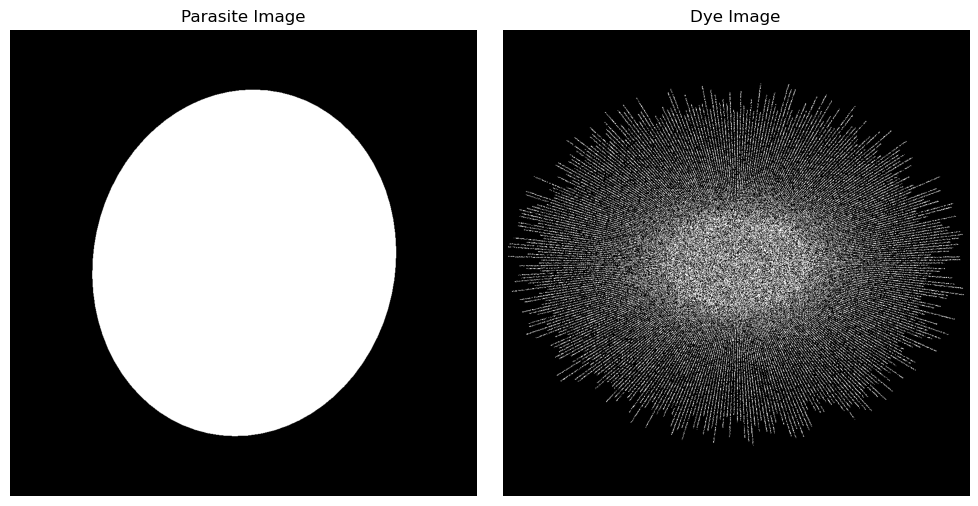

In [4]:
# Generate parasite and dye distribution images
parasite_img, img1 = generate_complex_blob()

# Determine if this iteration should simulate cancer
is_cancerous = True
dye_img = generate_dye_distribution(img1, is_cancerous=is_cancerous)

# Output the results
print(f"Parasite has {'cancer' if has_cancer(parasite_img, dye_img) else 'no cancer'}.")

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

small_dye_img = cv2.resize(dye_img, (1000, 1000))  # Resize to 1000x1000 or another manageable size
small_parasite_img = cv2.resize(parasite_img, (1000, 1000))  # Resize to 1000x1000 or another manageable size


# Display the parasite image (Resized)
plt.subplot(1, 2, 1)
plt.imshow(small_parasite_img, cmap='gray')
plt.title('Parasite Image')
plt.axis('off')

# Display the dye image (Resized)
plt.subplot(1, 2, 2)
plt.imshow(small_dye_img, cmap='gray')
plt.title('Dye Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
print(parasite_img.shape)
print(dye_img.shape)
print(small_parasite_img.shape)
print(small_dye_img.shape)

(100000, 100000)
(100000, 100000)
(1000, 1000)
(1000, 1000)


In [6]:
# Saving Images

import h5py

with h5py.File('images.hdf5', 'w') as f:
    # Use compression such as 'gzip', 'lzf', or 'szip'
    f.create_dataset('parasite_img', data=parasite_img, compression='gzip')
    f.create_dataset('dye_img', data=dye_img, compression='gzip')

In [7]:
# Loading Images

# import h5py
# import numpy as np
# import matplotlib.pyplot as plt

# # Open the HDF5 file for reading
# with h5py.File('images.hdf5', 'r') as file:
#     # Access the images from the file
#     parasite_img = np.array(file['parasite_img'])
#     dye_img = np.array(file['dye_img'])

#     # Now 'parasite_img' and 'dye_img' are NumPy arrays containing your images

**Total Execution Time: 210 seconds = ~3.5 minutes**

**Total Storage required to save both the images: ~500 MB**

# Parasite with No Cancer

Moving forward, I'll suggest restarting the kernel to produce this next set of images for Parasite with no cancer to avoid kernel crash (if using 16 GPU RAM).

**If you're restarting the kernel, make sure to run the first cell (cell before Parasite with Cancer), before running below cells**

generate_complex_blob execution time: 9.0980 seconds
generate_dye_distribution execution time: 130.6443 seconds
has_cancer execution time: 42.6247 seconds
Parasite has no cancer.


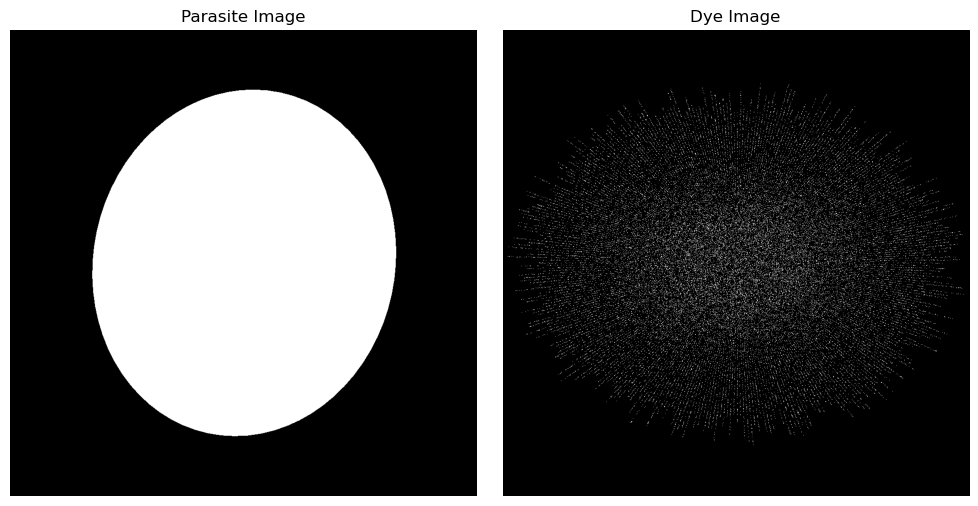

In [3]:
# Generate parasite and dye distribution images
non_parasite_img, non_img1 = generate_complex_blob()

# Determine if this iteration should simulate cancer
is_cancerous = False
non_dye_img = generate_dye_distribution(non_img1, is_cancerous=is_cancerous)

# Output the results
print(f"Parasite has {'cancer' if has_cancer(non_parasite_img, non_dye_img) else 'no cancer'}.")

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

small_non_dye_img = cv2.resize(non_dye_img, (1000, 1000))  # Resized to 1000x1000 
small_non_parasite_img = cv2.resize(non_parasite_img, (1000, 1000))  # Resized to 1000x1000

# Display the parasite image (Resized)
plt.subplot(1, 2, 1)
plt.imshow(small_non_parasite_img, cmap='gray')
plt.title('Parasite Image')
plt.axis('off')

# Display the dye image (Resized)
plt.subplot(1, 2, 2)
plt.imshow(small_non_dye_img, cmap='gray')
plt.title('Dye Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
print(non_parasite_img.shape)
print(non_dye_img.shape)
print(small_non_parasite_img.shape)
print(small_non_dye_img.shape)

(100000, 100000)
(100000, 100000)
(1000, 1000)
(1000, 1000)


In [5]:
# Saving Images

import h5py

with h5py.File('non_images.hdf5', 'w') as f:
    # Use compression such as 'gzip', 'lzf', or 'szip'
    f.create_dataset('non_parasite_img', data=non_parasite_img, compression='gzip')
    f.create_dataset('non_dye_img', data=non_dye_img, compression='gzip')

In [6]:
# Loading Images

# import h5py
# import numpy as np
# import matplotlib.pyplot as plt

# # Open the HDF5 file for reading
# with h5py.File('non_images.hdf5', 'r') as file:
#     # Access the images from the file
#     non_parasite_img = np.array(file['non_parasite_img'])
#     non_dye_img = np.array(file['non_dye_img'])

#     # Now 'non_parasite_img' and 'non_dye_img' are NumPy arrays containing your images

**Total Execution Time: 200 seconds = ~3.5 minutes**

**Total Storage required to save both the images: ~415 MB**